# Generates Figures: Regional Timeseries

In [1]:
from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import util
plt.style.use('ggplot')


In [5]:
# load transformed data
ds_djf_regional = xr.open_zarr('data/cesm-le-djf-triregion-timeseries.zarr')
ds_djf = ds_djf_regional[['SST', 'Chl_surf', 'KGP']].sel(length=40)

#ds_djf_alt = ds_djf_regional[['SST', 'Chl_surf', 'KGP', 'NPP', 'Jint_100m_DIC']]
ds_djf

<xarray.Dataset>
Dimensions:    (member_id: 34, region: 5, time: 180)
Coordinates:
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * region     (region) <U17 'Southern Ocean' 'WAP & Atlantic' ... 'AP Sector'
    length     float64 40.0
Data variables:
    SST        (time, member_id, region) float64 dask.array<chunksize=(180, 34, 5), meta=np.ndarray>
    Chl_surf   (time, member_id, region) float64 dask.array<chunksize=(180, 34, 5), meta=np.ndarray>
    KGP        (time, member_id, region) float64 dask.array<chunksize=(90, 34, 5), meta=np.ndarray>

## Compute the properties of the unperturbed climate

The mean

In [6]:
ds_ctrl_mean = (
        ds_djf.sel(time=slice(1920, 1950))
        .mean(dim=['time', 'member_id'])
        .compute()
)
ds_ctrl_mean

<xarray.Dataset>
Dimensions:   (region: 5)
Coordinates:
  * region    (region) <U17 'Southern Ocean' 'WAP & Atlantic' ... 'AP Sector'
    length    float64 40.0
Data variables:
    SST       (region) float64 4.782 4.31 4.44 4.408 4.782
    Chl_surf  (region) float64 0.7665 1.003 1.244 0.9447 0.7665
    KGP       (region) float64 0.009773 0.01508 0.01952 0.01339 0.009773

Standard deviation of anomalies

In [7]:
ds_ctrl_std = (
        (ds_djf - ds_djf.mean(dim=['member_id']).sel(time=slice(1920, 1950)))
        .std(dim=['time', 'member_id'])
        .compute()
)
ds_ctrl_std

<xarray.Dataset>
Dimensions:   (region: 5)
Coordinates:
  * region    (region) <U17 'Southern Ocean' 'WAP & Atlantic' ... 'AP Sector'
    length    float64 40.0
Data variables:
    SST       (region) float64 0.1896 0.1848 0.2251 0.1817 0.1896
    Chl_surf  (region) float64 0.04342 0.09069 0.1197 0.08233 0.04342
    KGP       (region) float64 0.00237 0.003098 0.003637 0.002917 0.00237

In [8]:
def assess_toe(da):
    """ compute toe on the basis of henson et al 2017
    
    To calculate the ToE, ﬁrst the time series of annual extrema in the conjoined historical
    and warming scenario runs is created. Then, an inﬂection point is located by calculating
    the cumulative sum of the gradient in Yt (qY/qt) and identifying the year when it
    exceeds zero (for a positive trend) or drops below zero (for a negative trend) for the
    remainder of the time series—we refer to this as the start of the climate change signal
    The trend in Yt is then calculated from that start point forward to 2100 using numpy's polyfit function.
    
    The natural variability (or noise) is deﬁned as one standard deviation in annual extrema 
    of a 100-year section of the model’s control run. As a consequence, the natural variability 
    as deﬁned here accounts for only the unforced natural variability,
    excluding the inﬂuence of changing incoming solar radiation or volcanoes.
    The ToE is then deﬁned as: ToE = (2 σ) / slope
    """
    # compute anomalies
    da_ref = da.sel(time=slice(1920, 1950)).mean(['time', 'member_id']).values
    da_ref_std = da.sel(time=slice(1920, 1950)).std(['time', 'member_id']).values
    anom = da.mean('member_id') - da_ref

    # Calculate cumulative integral
    time = da.time.values
    anom_cumtrapz = integrate.cumtrapz(anom.values, time, initial=0)
    
    # creates a boolean array where values of the anomaly @ the 'end' of the time series 
    # that are greater than zero are assigned a 1 and less than zero are assigned a -1 everywhere else
    int_sign = np.where(anom.isel(time=-1).values > 0, 1, -1)

    # find the inflection point
    int_thresh = anom_cumtrapz * int_sign 
    
    ndx = None
    for l in range (len(time)):
           if all (int_thresh[l:] > 0):
        #if all (np.abs(int_thresh[l:]) > 0):
            ndx = l
            break #once it finds the year where the trend declines, break, then...
    # compute trend year and slope after inflection point
    if ndx is None:
        return tuple(np.nan for i in range(5))
    cc_yr = time[ndx]

    beta = np.polyfit(time[ndx:], anom[ndx:], 1)
    cc_slope = beta[0]
    cc_intercept = beta[1]

    # compute time of emergence: ToE = (2 σ) / slope
    toe = np.abs((2 * da_ref_std) / cc_slope)
    # calculate year of ToE (as an integral)
    toe_yr = int(cc_yr + toe)
    
    return time[ndx], cc_slope, cc_intercept, toe_yr,  toe

## Import ToE data

In [9]:
# load transformed data
ds_toe = xr.open_zarr('data/cesm-le-fields-djf-Henson-ToE-ts.zarr')
ds_toe

<xarray.Dataset>
Dimensions:             (region: 5)
Coordinates:
    length              float64 ...
  * region              (region) object 'Southern Ocean' ... 'AP Sector'
Data variables:
    Chl_surf_inflect    (region) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    Chl_surf_intercept  (region) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    Chl_surf_slope      (region) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    Chl_surf_toe        (region) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    Chl_surf_toetime    (region) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    KGP_inflect         (region) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    KGP_intercept       (region) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    KGP_slope           (region) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    KGP_toe             (region) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    KGP_toetime         (region) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    SST_inflect         (region) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    SST_intercept       (region) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    SST_slope           (region) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    SST_toe             (region) float64 dask.array<chunksize=(5,), meta=np.ndarray>
    SST_toetime         (region) float64 dask.array<chunksize=(5,), meta=np.ndarray>

# Plot a single variable and region

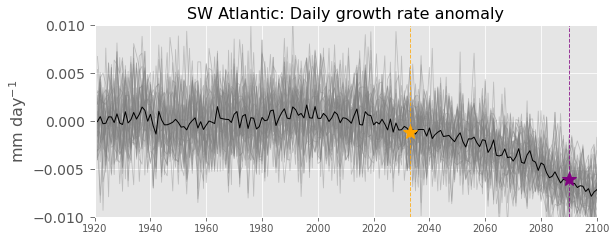

In [11]:
region = 'SW Atlantic'
extra = 'henson'
v = 'KGP'
unit = 'mm day$^{-1}$'
limYMin,limYMax = -0.01,0.01

cc_year = ds_toe['KGP_inflect'].sel(region=region)
cc_slope = ds_toe['KGP_slope'].sel(region=region)
cc_int = ds_toe['KGP_intercept'].sel(region=region)
toe_yr = ds_toe['KGP_toe'].sel(region=region)

#####################################
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
#plt.suptitle(f'{region}', fontsize = 18, fontweight = 'bold')
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf_regional.member_id:
    var_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.)
    ref_i = ds_djf_regional[v].sel(member_id=m_id, region=region, length = 40.).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf_regional.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)
    
ax.plot(ds_djf_regional.time, var_i - ref_i, '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])
anom = ds_djf[v].sel(region=region).mean('member_id') - ref
ax.plot(ds_djf.time, anom,'-', linewidth=1, color='k')

# plot reference lines: start of climate change and toe
ax.axvline(cc_year, lw=1, color='orange', linestyle='--', alpha = .75)
ax.plot(int(cc_year.values), anom.sel(time=cc_year).values, color = 'orange', marker='*', markersize=15)
ax.axvline(toe_yr, lw=1, color='purple', linestyle='--', alpha = .75)
ax.plot(int(toe_yr.values), anom.sel(time=toe_yr).values, color = 'purple', marker='*', markersize=15)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel(unit, fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = f'{region}: {ds_djf[v].long_name} anomaly'
ax.set_title(title, fontsize = 16);

# # title = (f'{title}-{region}-anomaly-EM')
# path = 'figures/'
# file = '.pdf'
# plt.savefig(path + title + extra + file, transparent=False, bbox_inches='tight')

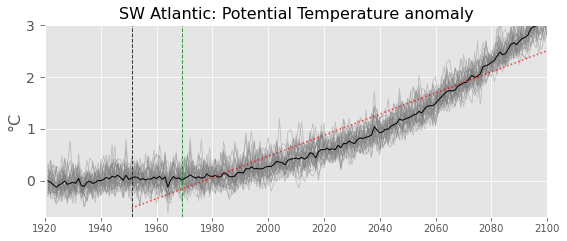

In [45]:
region = 'SW Atlantic'
extra = 'henson'
v = 'SST'
unit = '°C'
limYMin,limYMax = -0.7, 3

cc_year = ds_toe['SST_inflect'].sel(region=region)
cc_slope = ds_toe['SST_slope'].sel(region=region)
cc_int = ds_toe['SST_intercept'].sel(region=region)
toe_yr = ds_toe['SST_toe'].sel(region=region)

#####################################
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
#plt.suptitle(f'{region}', fontsize = 18, fontweight = 'bold')
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf.member_id:
    var_i = ds_djf[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1960')).mean(['time'])
    ax.plot(ds_djf.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.4)
    
ax.plot(ds_djf.time, var_i - ref_i, '-', linewidth=0.8, color = 'grey', alpha = 0.4)

ref = ds_djf[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])

ax.plot(ds_djf.time, ds_djf[v].sel(region=region).mean('member_id') - ref,
        '-', linewidth=1, color='k')

# plot reference lines: start of climate change and toe
ax.axvline(cc_year, lw=1, color='k', linestyle='--', alpha = .75)
ax.axvline(toe_yr, lw=1, color='g', linestyle='--', alpha = .75)

# Create a list of values in the best fit line
abline_values = [cc_slope * i + cc_int for i in ds_djf.sel(time=slice(cc_year, 2100)).time]
ax.plot(ds_djf.sel(time=slice(cc_year, 2100)).time, abline_values, 'r', linestyle=':', alpha = .75, label = 'ω')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel(unit, fontsize = 16)
ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
title = f'{region}: {ds_djf[v].long_name} anomaly'
ax.set_title(title, fontsize = 16);

# title = (f'{title}-{region}-anomaly-EM')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + extra + file, transparent=False, bbox_inches='tight')

# Plot EVERY region:
## KGP

In [26]:
[toe_yr < 15]

<xarray.DataArray 'KGP_toe' ()>
dask.array<getitem, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    length   float64 ...
    region   <U17 'Atlantic Quadrant'
Attributes:
    long_name:  Daily growth rate
    notes:      computed using raw model field
    units:      mm d$^{-1}$

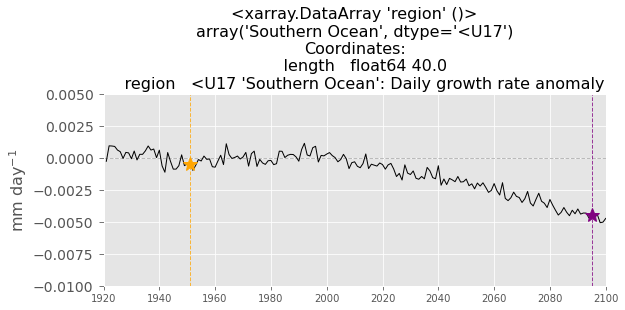

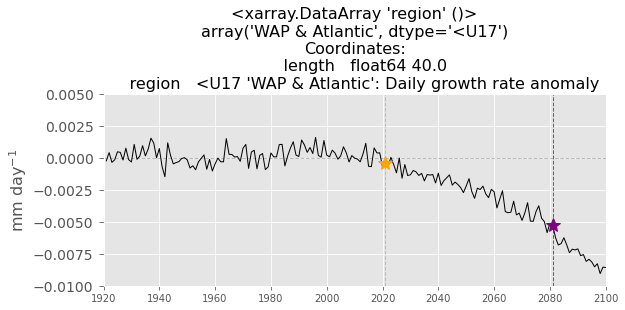

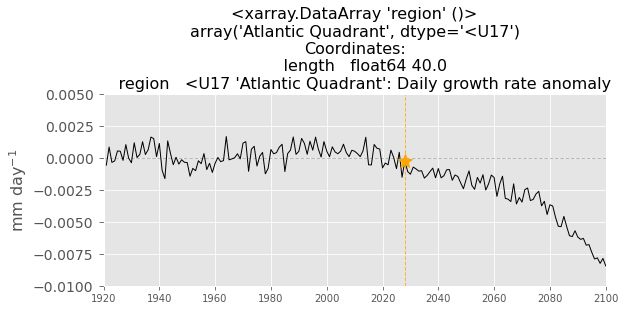

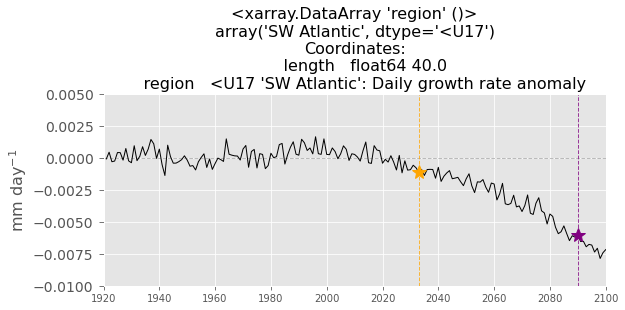

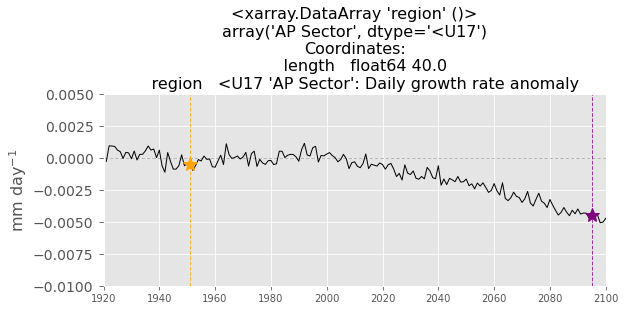

In [41]:
for region in ds_djf.region:
    extra = 'henson-simple'
    v = 'KGP'
    unit = 'mm day$^{-1}$'
    limYMin,limYMax = -0.01,0.005

    cc_year = ds_toe['KGP_inflect'].sel(region=region)
    cc_slope = ds_toe['KGP_slope'].sel(region=region)
    cc_int = ds_toe['KGP_intercept'].sel(region=region)
    toe_yr = ds_toe['KGP_toe'].sel(region=region)#.where(toe_yr > 2100)
        
    #####################################
    fig = plt.figure(figsize=(9, 12))
    gs = gridspec.GridSpec(3,1)
    #plt.suptitle(f'{region}', fontsize = 18, fontweight = 'bold')
    #####################################
    ax = fig.add_subplot(gs[0, 0])
    ax.set_xlim((1920, 2100))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ref = ds_djf[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])
    anom = ds_djf[v].sel(region=region).mean('member_id') - ref
    ax.plot(ds_djf.time, anom,'-', linewidth=1, color='k')

    # plot reference lines: start of climate change and toe
    ax.axhline(0, lw=1, color='k', linestyle='--',alpha = .25)
    ax.axvline(cc_year, lw=1, color='orange', linestyle='--', alpha = .75)
    ax.plot(int(cc_year.values), anom.sel(time=cc_year).values, color = 'orange', marker='*', markersize=15)
    if np.max(toe_yr)<2101:
        ax.axvline(toe_yr, lw=1, color='purple', linestyle='--', alpha = .75)
        ax.plot(int(toe_yr.values), anom.sel(time=toe_yr).values, color = 'purple', marker='*', markersize=15)  
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax.set_ylim([limYMin, limYMax])
    ax.set_ylabel(unit, fontsize = 16)
    ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
    title = f'{region}: {ds_djf[v].long_name} anomaly'
    ax.set_title(title, fontsize = 16);

    # title = (f'{title}-{region}-anomaly-EM')
    path = 'figures/'
    file = '.pdf'
    plt.savefig(path + title + extra + file, transparent=False, bbox_inches='tight')


## SST

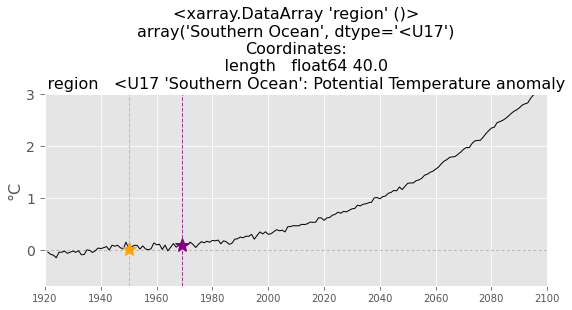

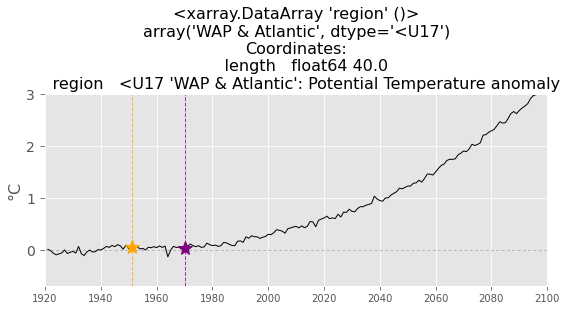

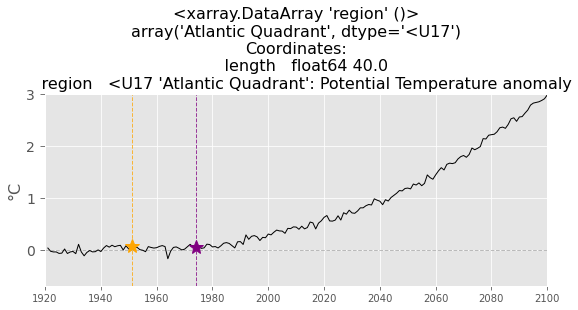

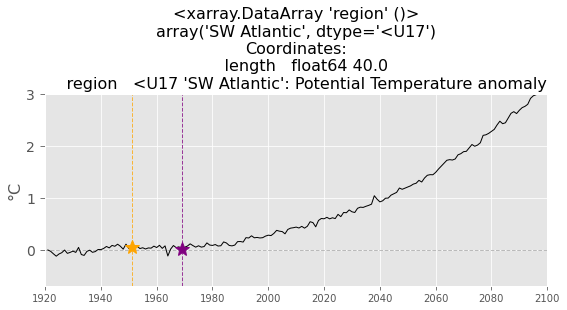

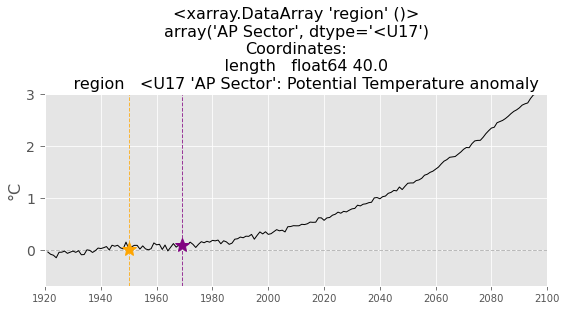

In [43]:
for region in ds_djf.region:
    extra = 'henson'
    v = 'SST'
    unit = '°C'
    limYMin,limYMax = -0.7, 3

    cc_year = ds_toe['SST_inflect'].sel(region=region)
    cc_slope = ds_toe['SST_slope'].sel(region=region)
    cc_int = ds_toe['SST_intercept'].sel(region=region)
    toe_yr = ds_toe['SST_toe'].sel(region=region)

    #####################################
    fig = plt.figure(figsize=(9, 12))
    gs = gridspec.GridSpec(3,1)
    #plt.suptitle(f'{region}', fontsize = 18, fontweight = 'bold')
    #####################################
    ax = fig.add_subplot(gs[0, 0])
    ax.set_xlim((1920, 2100))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ref = ds_djf[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])
    anom = ds_djf[v].sel(region=region).mean('member_id') - ref
    ax.plot(ds_djf.time, anom,'-', linewidth=1, color='k')

    # plot reference lines: start of climate change and toe
    ax.axhline(0, lw=1, color='k', linestyle='--',alpha = .25)
    ax.axvline(cc_year, lw=1, color='orange', linestyle='--', alpha = .75)
    ax.plot(int(cc_year.values), anom.sel(time=cc_year).values, color = 'orange', marker='*', markersize=15)
    if np.max(toe_yr)<2101:
        ax.axvline(toe_yr, lw=1, color='purple', linestyle='--', alpha = .75)
        ax.plot(int(toe_yr.values), anom.sel(time=toe_yr).values, color = 'purple', marker='*', markersize=15)  
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax.set_ylim([limYMin, limYMax])
    ax.set_ylabel(unit, fontsize = 16)
    ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
    title = f'{region}: {ds_djf[v].long_name} anomaly'
    ax.set_title(title, fontsize = 16);

    # title = (f'{title}-{region}-anomaly-EM')
    path = 'figures/'
    file = '.pdf'
    plt.savefig(path + title + extra + file, transparent=False, bbox_inches='tight')

## Chl

/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/dask/utils.py:30: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN axis encountered
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/dask/utils.py:30: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN axis encountered
  return func(*(_execute_task(a, cache) for a in args))
/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/dask/utils.py:30: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/glade/work/zephyrs/miniconda3/envs/krill-2/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN axis encountered
  retu

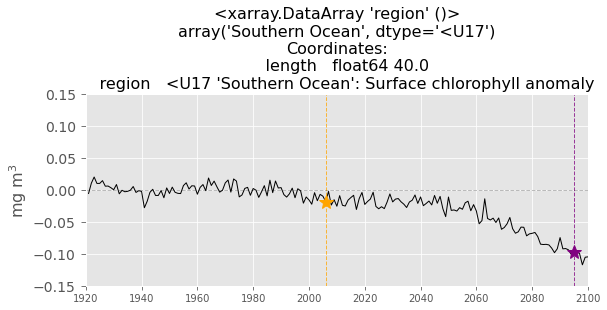

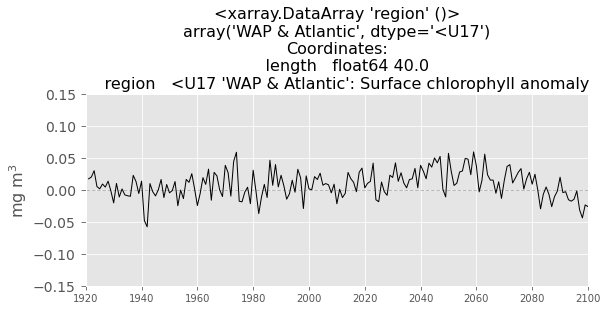

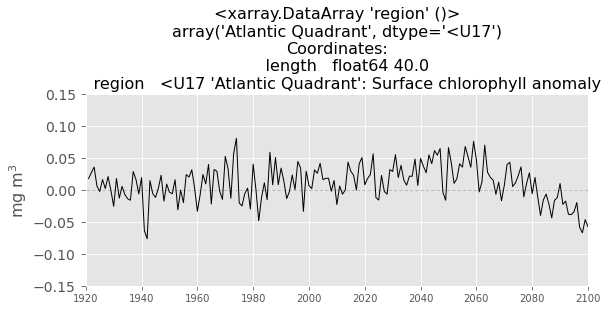

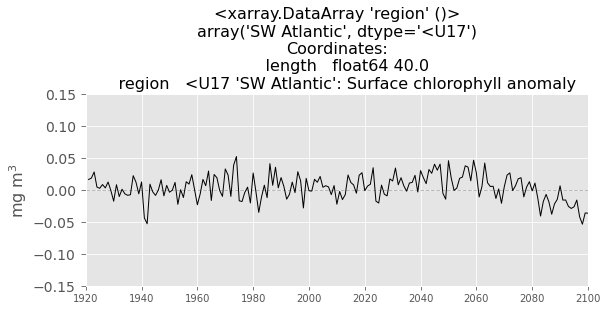

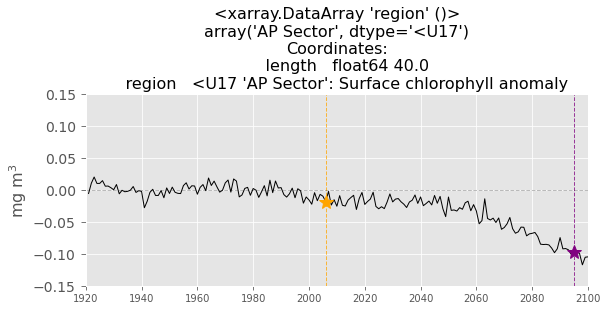

In [44]:
for region in ds_djf.region:
    extra = 'henson'
    v = 'Chl_surf'
    unit = 'mg m$^3$'
    limYMin,limYMax = -0.15, 0.15
    
    cc_year = ds_toe['Chl_surf_inflect'].sel(region=region)
    cc_slope = ds_toe['Chl_surf_slope'].sel(region=region)
    cc_int = ds_toe['Chl_surf_intercept'].sel(region=region)
    toe_yr = ds_toe['Chl_surf_toe'].sel(region=region)

    #####################################
    fig = plt.figure(figsize=(9, 12))
    gs = gridspec.GridSpec(3,1)
    #plt.suptitle(f'{region}', fontsize = 18, fontweight = 'bold')
    #####################################
    ax = fig.add_subplot(gs[0, 0])
    ax.set_xlim((1920, 2100))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ref = ds_djf[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])
    anom = ds_djf[v].sel(region=region).mean('member_id') - ref
    ax.plot(ds_djf.time, anom,'-', linewidth=1, color='k')

    # plot reference lines: start of climate change and toe
    if np.max(cc_year)<2101:
        ax.axvline(cc_year, lw=1, color='orange', linestyle='--', alpha = .75)
        ax.plot(int(cc_year.values), anom.sel(time=cc_year).values, color = 'orange', marker='*', markersize=15)
    if np.max(toe_yr)<2101:
        ax.axvline(toe_yr, lw=1, color='purple', linestyle='--', alpha = .75)
        ax.plot(int(toe_yr.values), anom.sel(time=toe_yr).values, color = 'purple', marker='*', markersize=15)  
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ax.axhline(0, lw=1, color='k', linestyle='--',alpha = .25)
    ax.set_ylim([limYMin, limYMax])
    ax.set_ylabel(unit, fontsize = 16)
    ax.tick_params(axis='y', which='major', length=5, pad=5, labelsize=14)
    title = f'{region}: {ds_djf[v].long_name} anomaly'
    ax.set_title(title, fontsize = 16);

    # title = (f'{title}-{region}-anomaly-EM')
    path = 'figures/'
    file = '.pdf'
    plt.savefig(path + title + extra + file, transparent=False, bbox_inches='tight')


## Simple Single Region Plots

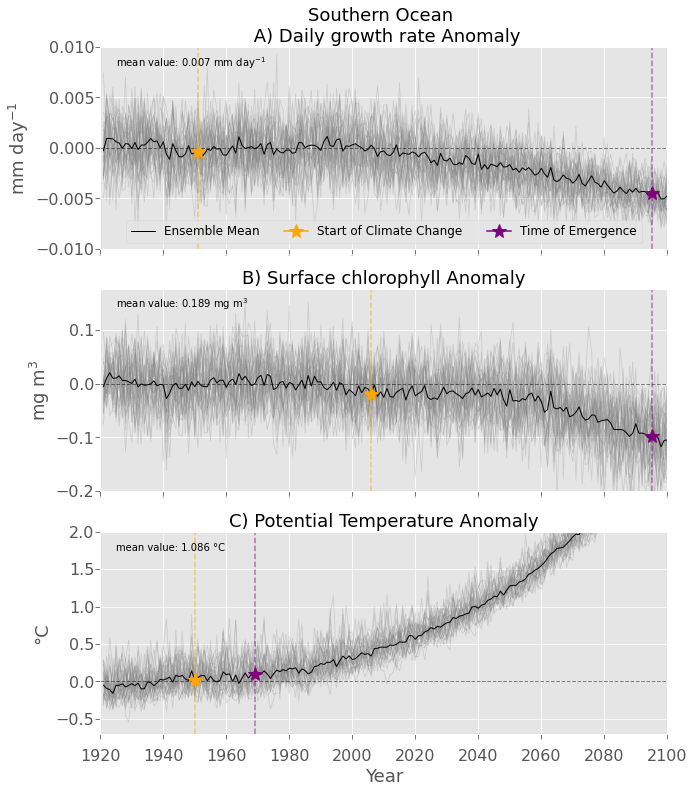

In [29]:
extra = 'Henson'
region = 'Southern Ocean'

#####################################
fig = plt.figure(figsize=(9, 12))
gs = gridspec.GridSpec(3,1)
#plt.suptitle(f'{region}', fontsize = 18, fontweight = 'bold')
################   KGP.  ################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
v = 'KGP'
unit = 'mm day$^{-1}$'
limYMin,limYMax = -0.01,0.01

cc_year = ds_toe['KGP_inflect'].sel(region=region)
cc_slope = ds_toe['KGP_slope'].sel(region=region)
cc_int = ds_toe['KGP_intercept'].sel(region=region)
toe_yr = ds_toe['KGP_toe'].sel(region=region)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf.member_id:
    var_i = ds_djf[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1950')).mean(['time'])
    ax.plot(ds_djf.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.25)

ref = ds_djf[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])
anom = ds_djf[v].sel(region=region).mean('member_id') - ref
ax.plot(ds_djf.time, anom,'-', linewidth=1, color='k', label='Ensemble Mean')

# plot reference lines: start of climate change and toe
ax.axhline(0, lw=1, color='k', linestyle='--',alpha = .5)
if np.max(cc_year)<2101:
    ax.axvline(cc_year, lw=1.5, color='orange', linestyle='--', alpha = .5)
    ax.plot(int(cc_year.values), anom.sel(time=cc_year).values, color = 'orange', marker='*', markersize=15,
            label='Start of Climate Change')
if np.max(toe_yr)<2101:
    ax.axvline(toe_yr, lw=1.5, color='purple', linestyle='--', alpha = .5)
    ax.plot(int(toe_yr.values), anom.sel(time=toe_yr).values, color = 'purple', marker='*', markersize=15,
            label='Time of Emergence')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.text(1925, 0.008, f'mean value: 0.007 {unit}')
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel(unit, fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=1, labelsize=16)
ax.tick_params(axis='x', which='major', length=5, pad=1, labelsize=1)
ax.legend(fontsize = 12, ncol=3, loc='lower center')
ax.set_title(f'{region} \n A) {ds_djf[v].long_name} Anomaly', pad=5,fontsize = 18)
ax.set_xlabel(' ', fontsize = 2)

################ CHL ###############
ax = fig.add_subplot(gs[1, 0])
ax.set_xlim((1920, 2100))
ax.set_xlabel(' ', fontsize = 2)

v = 'Chl_surf'
limYMin,limYMax = -0.2, 0.175
unit = 'mg m$^3$'

cc_year = ds_toe['Chl_surf_inflect'].sel(region=region)
cc_slope = ds_toe['Chl_surf_slope'].sel(region=region)
cc_int = ds_toe['Chl_surf_intercept'].sel(region=region)
toe_yr = ds_toe['Chl_surf_toe'].sel(region=region)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf.member_id:
    var_i = ds_djf[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1950')).mean(['time'])
    ax.plot(ds_djf.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.25)
    
ref = ds_djf[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])
anom = ds_djf[v].sel(region=region).mean('member_id') - ref
ax.plot(ds_djf.time, anom,'-', linewidth=1, color='k')
# plot reference lines: start of climate change and toe
ax.axhline(0, lw=1, color='k', linestyle='--',alpha = .5)
if np.max(cc_year)<2101:
    ax.axvline(cc_year, lw=1.5, color='orange', linestyle='--', alpha = .5)
    ax.plot(int(cc_year.values), anom.sel(time=cc_year).values, color = 'orange', marker='*', markersize=15)
if np.max(toe_yr)<2101:
    ax.axvline(toe_yr, lw=1.5, color='purple', linestyle='--', alpha = .5)
    ax.plot(int(toe_yr.values), anom.sel(time=toe_yr).values, color = 'purple', marker='*', markersize=15)  
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.text(1925, 0.14, f'mean value: 0.189 {unit}')
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel(unit, fontsize = 18)
ax.set_xlabel(' ', fontsize = 2)
ax.tick_params(axis='y', which='major', length=5, pad=1, labelsize=16)
ax.tick_params(axis='x', which='major', length=5, pad=1, labelsize=1)
ax.set_title(f'B) {ds_djf[v].long_name} Anomaly', fontsize = 18, pad=5)

###############  SST.  #################
ax = fig.add_subplot(gs[2, 0])
ax.set_xlim((1920, 2100))

v = 'SST'
unit = '°C'
limYMin,limYMax = -0.7, 2
cc_year = ds_toe['SST_inflect'].sel(region=region)
cc_slope = ds_toe['SST_slope'].sel(region=region)
cc_int = ds_toe['SST_intercept'].sel(region=region)
toe_yr = ds_toe['SST_toe'].sel(region=region)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
for m_id in ds_djf.member_id:
    var_i = ds_djf[v].sel(member_id=m_id, region=region)
    ref_i = ds_djf[v].sel(member_id=m_id, region=region).sel(time=slice('1920', '1950')).mean(['time'])
    ax.plot(ds_djf.time, var_i - ref_i,
           '-', linewidth=0.8, color = 'grey', alpha = 0.25)
    
ref = ds_djf[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])
anom = ds_djf[v].sel(region=region).mean('member_id') - ref
ax.plot(ds_djf.time, anom,'-', linewidth=1, color='k')
# plot reference lines: start of climate change and toe
ax.axhline(0, lw=1, color='k', linestyle='--',alpha = .5)
if np.max(cc_year)<2101:
    ax.axvline(cc_year, lw=1.5, color='orange', linestyle='--', alpha = .5)
    ax.plot(int(cc_year.values), anom.sel(time=cc_year).values, color = 'orange', marker='*', markersize=15)
if np.max(toe_yr)<2101:
    ax.axvline(toe_yr, lw=1.5, color='purple', linestyle='--', alpha = .5)
    ax.plot(int(toe_yr.values), anom.sel(time=toe_yr).values, color = 'purple', marker='*', markersize=15)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.text(1925, 1.75, f'mean value: 1.086 {unit}')
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel(unit, fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=1, labelsize=16)
ax.tick_params(axis='x', which='major',length=5, pad=10, labelsize=16)
ax.set_xlabel('Year', fontsize = 18)
ax.set_title(f'C) {ds_djf[v].long_name} Anomaly', pad=5, fontsize = 18)
#####################################
gs.update(hspace=.2, top=.92, right =1)

title = (f'{extra}-{region}-anomaly-EM')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')

In [38]:
region = 'Southern Ocean'
################   KGP.  ################
v = 'KGP'
cc_year = ds_toe['KGP_inflect'].sel(region=region).values
cc_slope = ds_toe['KGP_slope'].sel(region=region).values
cc_int = ds_toe['KGP_intercept'].sel(region=region).values
toe_yr = ds_toe['KGP_toe'].sel(region=region).values
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('KGP - Start of Climate Change: ', int(cc_year))
print('KGP - Time of Emergence: ', int(toe_yr))
print('KGP - Pace of Climate Change: ', int(toe_yr-cc_year))
################ CHL ###############
v = 'Chl_surf'
cc_year = ds_toe['Chl_surf_inflect'].sel(region=region).values
cc_slope = ds_toe['Chl_surf_slope'].sel(region=region).values
cc_int = ds_toe['Chl_surf_intercept'].sel(region=region).values
toe_yr = ds_toe['Chl_surf_toe'].sel(region=region).values
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('CHL - Start of Climate Change: ', int(cc_year))
print('CHL - Time of Emergence: ', int(toe_yr))
print('CHL - Pace of Climate Change: ', int(toe_yr-cc_year))
###############  SST.  #################
v = 'SST'
unit = '°C'
cc_year = ds_toe['SST_inflect'].sel(region=region).values
cc_slope = ds_toe['SST_slope'].sel(region=region).values
cc_int = ds_toe['SST_intercept'].sel(region=region).values
toe_yr = ds_toe['SST_toe'].sel(region=region).values
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('SST - Start of Climate Change: ', int(cc_year))
print('SST - Time of Emergence: ', int(toe_yr))
print('SST - Pace of Climate Change: ', int(toe_yr-cc_year))

KGP - Start of Climate Change:  1951
KGP - Time of Emergence:  2095
KGP - Pace of Climate Change:  144
CHL - Start of Climate Change:  2006
CHL - Time of Emergence:  2095
CHL - Pace of Climate Change:  89
SST - Start of Climate Change:  1950
SST - Time of Emergence:  1969
SST - Pace of Climate Change:  19


# Region Compare: Southern Ocean vs AP

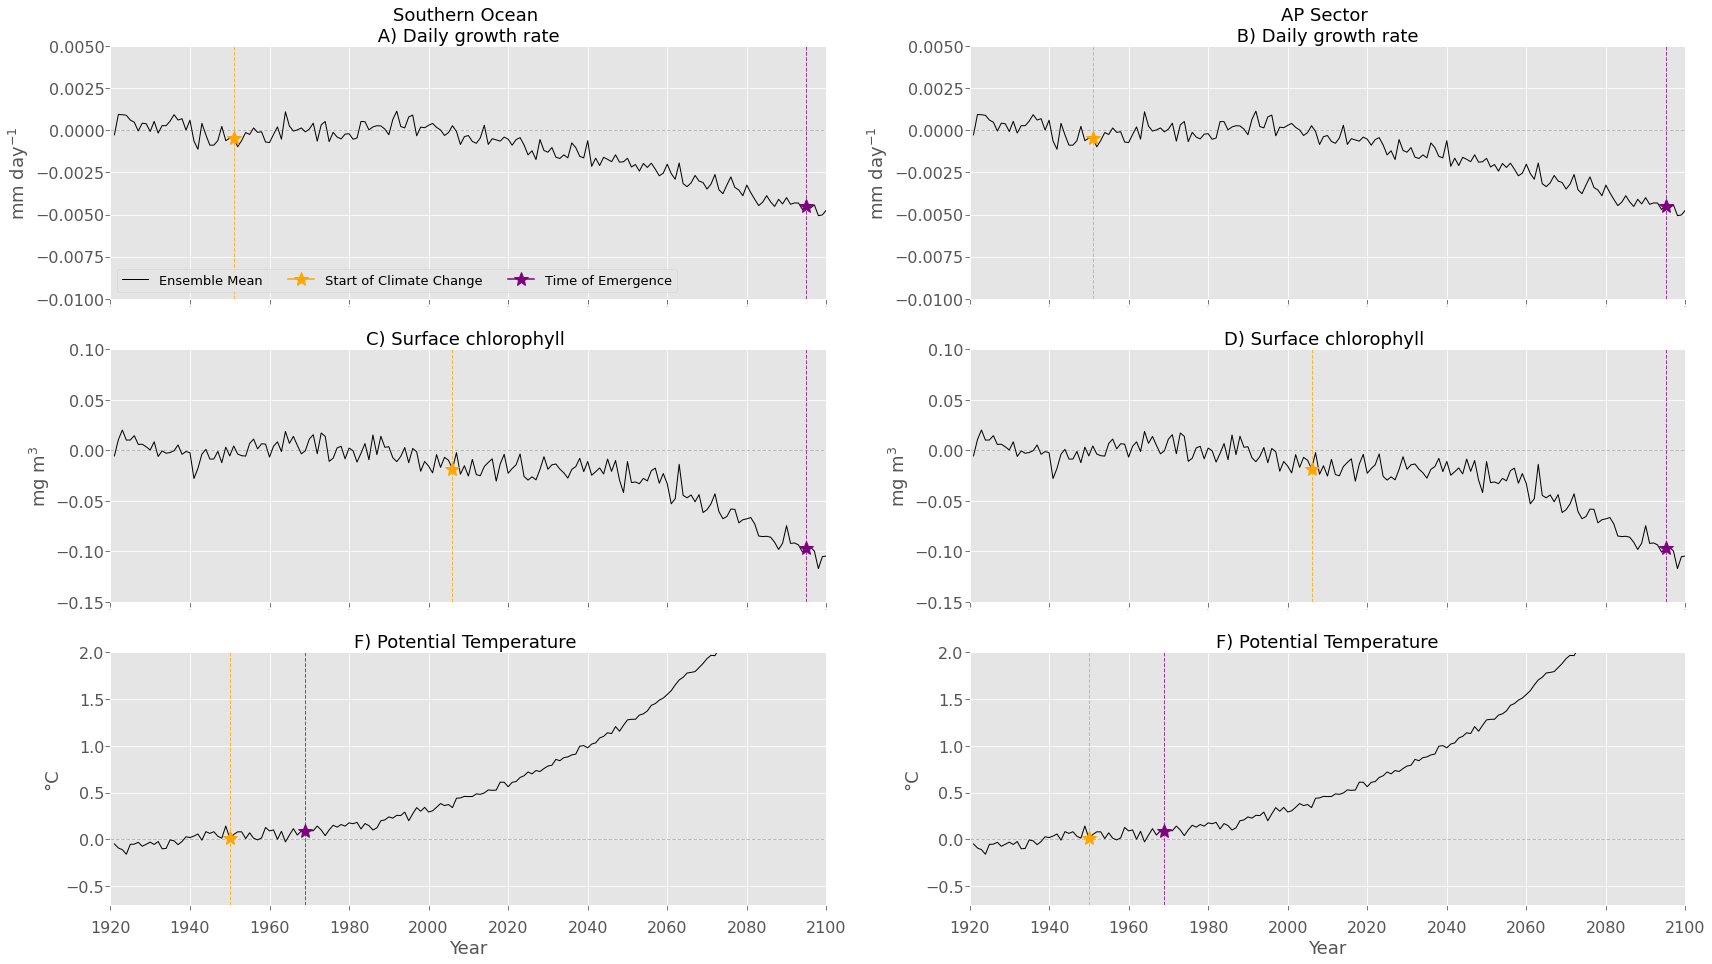

In [76]:
extra = 'TOE-Timeseries-Full'
region = 'Southern Ocean'

#####################################
fig = plt.figure(figsize=(25, 15))
gs = gridspec.GridSpec(3,2, width_ratios=[2,2])
#####################################
ax = fig.add_subplot(gs[0, 0])
ax.set_xlim((1920, 2100))
v = 'KGP'
unit = 'mm day$^{-1}$'
limYMin,limYMax = -0.01,0.005
cc_year = ds_toe['KGP_inflect'].sel(region=region)
cc_slope = ds_toe['KGP_slope'].sel(region=region)
cc_int = ds_toe['KGP_intercept'].sel(region=region)
toe_yr = ds_toe['KGP_toe'].sel(region=region)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref = ds_djf[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])
anom = ds_djf[v].sel(region=region).mean('member_id') - ref
ax.plot(ds_djf.time, anom,'-', linewidth=1, color='k', label='Ensemble Mean')

# plot reference lines: start of climate change and toe
ax.axhline(0, lw=1, color='k', linestyle='--',alpha = .25)
if np.max(cc_year)<2101:
    ax.axvline(cc_year, lw=1, color='orange', linestyle='--', alpha = .75)
    ax.plot(int(cc_year.values), anom.sel(time=cc_year).values,
            color = 'orange', marker='*', markersize=15,
            label='Start of Climate Change')
if np.max(toe_yr)<2101:
    ax.axvline(toe_yr, lw=1, color='purple', linestyle='--', alpha = .75)
    ax.plot(int(toe_yr.values), anom.sel(time=toe_yr).values,
            color = 'purple', marker='*', markersize=15,
            label='Time of Emergence')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel(unit, fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=1, labelsize=16)
ax.tick_params(axis='x', which='major', length=5, pad=1, labelsize=1)
ax.legend(loc='lower left', ncol=3,fontsize = 13)
ax.set_title(f'{region} \n A) {ds_djf[v].long_name} ', pad=5,fontsize = 18)
ax.set_xlabel(' ', fontsize = 2)

#####################################
ax = fig.add_subplot(gs[1, 0])
ax.set_xlim((1920, 2100))
ax.set_xlabel(' ', fontsize = 2)

v = 'Chl_surf'
limYMin,limYMax = -0.15, 0.1
unit = 'mg m$^3$'
cc_year = ds_toe['Chl_surf_inflect'].sel(region=region)
cc_slope = ds_toe['Chl_surf_slope'].sel(region=region)
cc_int = ds_toe['Chl_surf_intercept'].sel(region=region)
toe_yr = ds_toe['Chl_surf_toe'].sel(region=region)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref = ds_djf[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])
anom = ds_djf[v].sel(region=region).mean('member_id') - ref
ax.plot(ds_djf.time, anom,'-', linewidth=1, color='k')
# plot reference lines: start of climate change and toe
ax.axhline(0, lw=1, color='k', linestyle='--',alpha = .25)
if np.max(cc_year)<2101:
    ax.axvline(cc_year, lw=1, color='orange', linestyle='--', alpha = .75)
    ax.plot(int(cc_year.values), anom.sel(time=cc_year).values, color = 'orange', marker='*', markersize=15)
if np.max(toe_yr)<2101:
    ax.axvline(toe_yr, lw=1, color='purple', linestyle='--', alpha = .75)
    ax.plot(int(toe_yr.values), anom.sel(time=toe_yr).values, color = 'purple', marker='*', markersize=15)  
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel(unit, fontsize = 18)
ax.set_xlabel(' ', fontsize = 2)
ax.tick_params(axis='y', which='major', length=5, pad=1, labelsize=16)
ax.tick_params(axis='x', which='major', length=5, pad=1, labelsize=1)
ax.set_title(f'C) {ds_djf[v].long_name} ', fontsize = 18, pad=5)

#####################################
ax = fig.add_subplot(gs[2, 0])
ax.set_xlim((1920, 2100))

v = 'SST'
unit = '°C'
limYMin,limYMax = -0.7, 2
cc_year = ds_toe['SST_inflect'].sel(region=region)
cc_slope = ds_toe['SST_slope'].sel(region=region)
cc_int = ds_toe['SST_intercept'].sel(region=region)
toe_yr = ds_toe['SST_toe'].sel(region=region)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref = ds_djf[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])
anom = ds_djf[v].sel(region=region).mean('member_id') - ref
ax.plot(ds_djf.time, anom,'-', linewidth=1, color='k')
# plot reference lines: start of climate change and toe
ax.axhline(0, lw=1, color='k', linestyle='--',alpha = .25)
if np.max(cc_year)<2101:
    ax.axvline(cc_year, lw=1, color='orange', linestyle='--', alpha = .75)
    ax.plot(int(cc_year.values), anom.sel(time=cc_year).values, color = 'orange', marker='*', markersize=15)
if np.max(toe_yr)<2101:
    ax.axvline(toe_yr, lw=1, color='purple', linestyle='--', alpha = .75)
    ax.plot(int(toe_yr.values), anom.sel(time=toe_yr).values, color = 'purple', marker='*', markersize=15)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel(unit, fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=1, labelsize=16)
ax.tick_params(axis='x', which='major',length=5, pad=10, labelsize=16)
ax.set_xlabel('Year', fontsize = 18)
ax.set_title(f'F) {ds_djf[v].long_name} ', pad=5, fontsize = 18)
#####################################
gs.update(hspace=.2, top=.92, right =1)

region = 'AP Sector'

#####################################
ax = fig.add_subplot(gs[0, 1])
ax.set_xlim((1920, 2100))
v = 'KGP'
unit = 'mm day$^{-1}$'
limYMin,limYMax = -0.01,0.005
cc_year = ds_toe['KGP_inflect'].sel(region=region)
cc_slope = ds_toe['KGP_slope'].sel(region=region)
cc_int = ds_toe['KGP_intercept'].sel(region=region)
toe_yr = ds_toe['KGP_toe'].sel(region=region)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref = ds_djf[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])
anom = ds_djf[v].sel(region=region).mean('member_id') - ref
ax.plot(ds_djf.time, anom,'-', linewidth=1, color='k', label='Ensemble Mean')

# plot reference lines: start of climate change and toe
ax.axhline(0, lw=1, color='k', linestyle='--',alpha = .25)
if np.max(cc_year)<2101:
    ax.axvline(cc_year, lw=1, color='orange', linestyle='--', alpha = .75)
    ax.plot(int(cc_year.values), anom.sel(time=cc_year).values,
            color = 'orange', marker='*', markersize=15,label='Start of Climate Change')
if np.max(toe_yr)<2101:
    ax.axvline(toe_yr, lw=1, color='purple', linestyle='--', alpha = .75)
    ax.plot(int(toe_yr.values), anom.sel(time=toe_yr).values,
            color = 'purple', marker='*', markersize=15,label='Time of Emergence')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel(unit, fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=1, labelsize=16)
ax.tick_params(axis='x', which='major', length=5, pad=1, labelsize=1)
#ax.legend(fontsize = 12)
ax.set_title(f'{region} \n B) {ds_djf[v].long_name} ', pad=5,fontsize = 18)
ax.set_xlabel(' ', fontsize = 2)

#####################################
ax = fig.add_subplot(gs[1, 1])
ax.set_xlim((1920, 2100))
ax.set_xlabel(' ', fontsize = 2)

v = 'Chl_surf'
limYMin,limYMax = -0.15, 0.1
unit = 'mg m$^3$'
cc_year = ds_toe['Chl_surf_inflect'].sel(region=region)
cc_slope = ds_toe['Chl_surf_slope'].sel(region=region)
cc_int = ds_toe['Chl_surf_intercept'].sel(region=region)
toe_yr = ds_toe['Chl_surf_toe'].sel(region=region)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref = ds_djf[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])
anom = ds_djf[v].sel(region=region).mean('member_id') - ref
ax.plot(ds_djf.time, anom,'-', linewidth=1, color='k')
# plot reference lines: start of climate change and toe
ax.axhline(0, lw=1, color='k', linestyle='--',alpha = .25)
if np.max(cc_year)<2101:
    ax.axvline(cc_year, lw=1, color='orange', linestyle='--', alpha = .75)
    ax.plot(int(cc_year.values), anom.sel(time=cc_year).values, color = 'orange', marker='*', markersize=15)
if np.max(toe_yr)<2101:
    ax.axvline(toe_yr, lw=1, color='purple', linestyle='--', alpha = .75)
    ax.plot(int(toe_yr.values), anom.sel(time=toe_yr).values, color = 'purple', marker='*', markersize=15)  
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel(unit, fontsize = 18)
ax.set_xlabel(' ', fontsize = 2)
ax.tick_params(axis='y', which='major', length=5, pad=1, labelsize=16)
ax.tick_params(axis='x', which='major', length=5, pad=1, labelsize=1)
ax.set_title(f'D) {ds_djf[v].long_name} ', fontsize = 18, pad=5)

#####################################
ax = fig.add_subplot(gs[2, 1])
ax.set_xlim((1920, 2100))

v = 'SST'
unit = '°C'
limYMin,limYMax = -0.7, 2
cc_year = ds_toe['SST_inflect'].sel(region=region)
cc_slope = ds_toe['SST_slope'].sel(region=region)
cc_int = ds_toe['SST_intercept'].sel(region=region)
toe_yr = ds_toe['SST_toe'].sel(region=region)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ref = ds_djf[v].sel(region = region).sel(time=slice('1920', '1960')).mean(['member_id', 'time'])
anom = ds_djf[v].sel(region=region).mean('member_id') - ref
ax.plot(ds_djf.time, anom,'-', linewidth=1, color='k')
# plot reference lines: start of climate change and toe
ax.axhline(0, lw=1, color='k', linestyle='--',alpha = .25)
if np.max(cc_year)<2101:
    ax.axvline(cc_year, lw=1, color='orange', linestyle='--', alpha = .75)
    ax.plot(int(cc_year.values), anom.sel(time=cc_year).values, color = 'orange', marker='*', markersize=15)
if np.max(toe_yr)<2101:
    ax.axvline(toe_yr, lw=1, color='purple', linestyle='--', alpha = .75)
    ax.plot(int(toe_yr.values), anom.sel(time=toe_yr).values, color = 'purple', marker='*', markersize=15)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax.set_ylim([limYMin, limYMax])
ax.set_ylabel(unit, fontsize = 18)
ax.tick_params(axis='y', which='major', length=5, pad=1, labelsize=16)
ax.tick_params(axis='x', which='major',length=5, pad=10, labelsize=16)
ax.set_xlabel('Year', fontsize = 18)
ax.set_title(f'F) {ds_djf[v].long_name}', pad=5, fontsize = 18)
#####################################
gs.update(hspace=.2, top=.92, right =1)
#####################################
#gs.update(wspace=0.1, hspace=0.25, top=.92)
#gs.update(hspace=.2, top=.92)
###############
title = (f'{extra}-anomaly-EM')
path = 'figures/'
file = '.pdf'
plt.savefig(path + title + file, bbox_inches='tight')